In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import string
from keras.preprocessing.text import Tokenizer, text_to_word_sequence

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import spacy

# from nltk import word_tokenize, sent_tokenize
from string import punctuation
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.manifold import TSNE
from wordcloud import WordCloud

In [2]:
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('omw-1.4')

In [3]:
spacy.prefer_gpu()

True

In [4]:
nlp = spacy.load("en_core_web_sm")

# Preprocessing

## Functions

### Sunday 12 March

TO DO FOR the WEEK: <br>
    - add function to remove stopwords from pos_id X
1. og statement -> get pos -> pos_id
	- train_data['pos_id'] = train_data['statement'].apply(get_pos)

2. og statement -> # preprocess statement: words lemmatized and stopwords are removed -> pred_statement
	- train_data['pred_statement'] = train_data['statement'].apply(preprocess_statement)

3. pred_statement -> add to vocab dict: add preprocessed statements to vocab dict -> vocab_dict
	- vocabulary_dict = load_statement_vocab_dict(train_data)

4. vocab_dict, pred_statement -> getWordID(): turn preprocessed statements to vector -> val
	- train_data['word_id'] = train_data['pred_statement'].apply(lambda x: getWordId(x, vocabulary_dict)

**NOTE** it is generally fine to add pos tags without stopwords removed.
	in siddarthhari, padding used to put pos tags as separate input layer.

15 mar: <br>
    - extracted getWordId() from preprocess_statement()
    


### 19 March
TODO: 
1. POS tags - incorporate stop words into pos tags 
- update: no need since separate input.
2. preprocess_statement() - configure best ones. confirm lemmatizer works

In [5]:
pos_tags = { 'ADJ': 'adjective', 'ADP': 'adposition', 'ADV': 'adverb', 'AUX': 'auxiliary verb', 'CONJ': 'coordinating conjunction',
                    'DET': 'determiner', 'INTJ': 'interjection', 'NOUN': 'noun',  'NUM': 'numeral', 'PART': 'particle', 'PRON': 'pronoun',
                    'PROPN': 'proper noun', 'PUNCT': 'punctuation', 'X': 'other', 'SCONJ': 'subordinating conjunction', 'SYM': 'symbol', 'VERB': 'verb'}

# proposed pos_dict: values correspond to pos tag importance
dict1 = {'NOUN': 0, 'VERB': 1, 'ADJ': 2, 'ADV': 3, 'ADP': 4, 'PRON': 5,
              'NUM': 6, 'SCONJ': 7, 'PROPN': 8, 'CONJ': 9, 'PUNCT': 10, 'AUX': 11,
              'PART': 12, 'INTJ': 13, 'DET': 14, 'SYM': 14, 'X': 14}

dict2 = {'ADJ': 0, 'ADP': 1, 'ADV': 2, 'AUX': 3, 'CONJ': 4,
              'DET': 5, 'INTJ': 6, 'NOUN': 7, 'NUM': 8, 'PART': 9,
              'PRON': 10, 'PROPN': 11, 'PUNCT': 12, 'X': 13,  'SCONJ': 14, 'SYM': 15, 'VERB': 16}

In [6]:
def get_pos(statement, pos_dict):
    doc = nlp(statement)
    taglist = []
    for token in doc:
        # labels stopwords from list of pos tags as 12
        # if token.is_stop:
        #     taglist.append(12)
        # else:
            taglist.append(pos_dict.get(token.pos_, max(pos_dict.values())))
    return taglist

In [6]:
from collections import defaultdict

def get_pos2(statement, pos_dict):
    tag_dict = defaultdict(lambda: max(pos_dict.values()), pos_dict)
    taglist = [tag_dict[token.pos_] for token in nlp(statement)]
    return taglist


In [20]:
def preprocess_statement(statement, pos_remove=None, spacy_stopword_removal=False):
# lemmatizes and lowercases tokens that are not punctuation or whitespace.
# params: statement - string
#         exclude_pos - list of POS tags to exclude from word list
#         remove_stopwords - removes stopwords based on pretrained spacy model
#         **warning** not recommended to toggle both params to True
# returns: tokens joined into a string
    doc = nlp(statement)
    words = []
    for token in doc:
        # check if token should be excluded based on part of speech or stopword status
        if pos_remove and token.pos_ in pos_remove:
            continue
        if spacy_stopword_removal and token.is_stop:
            continue
        # only include tokens that are not punctuation or whitespace
        if not token.is_punct and not token.is_space:
            # lemmatize and lowercase
            words.append(token.lemma_.lower())
    return ' '.join(words)

In [7]:
def preprocess_statement2(statement, pos_remove=None, spacy_stopword_removal=False):
    # lemmatizes and lowercases tokens that are not punctuation or whitespace.
    # params: statement - string
    # exclude_pos - list of POS tags to exclude from word list
    # remove_stopwords - removes stopwords based on pretrained spacy model
    # **warning** not recommended to toggle both params to True
    # returns: tokens joined into a string

    words = (token.lemma_.lower() for token in nlp(statement)
             if not token.is_punct and not token.is_space and
             (not pos_remove or token.pos_ not in pos_remove) and
             (not spacy_stopword_removal or not token.is_stop))

    return ' '.join(words)


In [14]:
# checks if vocabulary.p exists, if not creates it
def load_statement_vocab_dict(train_data):
    if not os.path.exists('vocabulary.p'):
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(train_data['pred_statement'])
        vocabulary_dict = tokenizer.word_index
        print(len(vocabulary_dict))
        with open("vocabulary.p", "wb") as f:
            pickle.dump(vocabulary_dict, f)
        print('Created Vocabulary Dictionary...')
        print('Saved Vocabulary Dictionary...')
    else:
        print('Loading Vocabulary Dictionary...')
        with open("vocabulary.p", "rb") as f:
            vocabulary_dict = pickle.load(f)
    return vocabulary_dict

In [15]:
def create_statement_vocab_dict2(data, column_name):

    vocab_file_name = f"vocabulary_{column_name}.p"

    if os.path.exists(vocab_file_name):
        with open(vocab_file_name, "rb") as f:
            old_vocabulary_dict = pickle.load(f)
        if column_name in old_vocabulary_dict:
            os.remove(vocab_file_name)
            print(f"Deleted existing Vocabulary Dictionary for column {column_name}...")
        else:
            print(f"Existing Vocabulary Dictionary does not match column {column_name}. Creating new Vocabulary Dictionary...")

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data[column_name])
    vocabulary_dict = tokenizer.word_index
    print(f"Created Vocabulary Dictionary for column {column_name}.")
    print('Size: ' + str(len(vocabulary_dict)))
    with open(vocab_file_name, "wb") as f:
        pickle.dump(vocabulary_dict, f)
    print(f"Saved Vocabulary Dictionary as {vocab_file_name}")

    return vocabulary_dict

In [16]:
def create_statement_vocab_dict3(data, column_name):
    vocab_file_name = f"vocabulary_{column_name}.p"

    if os.path.exists(vocab_file_name):
        print(f"Loading existing Vocabulary Dictionary for column {column_name}...")
        with open(vocab_file_name, "rb") as f:
            vocabulary_dict = pickle.load(f)
        print(f'Size: {len(vocabulary_dict)}')
    else:
        print(f"Creating new Vocabulary Dictionary for column {column_name}...")
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(data[column_name])
        vocabulary_dict = tokenizer.word_index
        print(f"Created Vocabulary Dictionary for column {column_name}.")
        print(f'Size: {len(vocabulary_dict)}')
        with open(vocab_file_name, "wb") as f:
            pickle.dump(vocabulary_dict, f)
        print(f"Saved Vocabulary Dictionary as {vocab_file_name}")

    return vocabulary_dict

In [8]:
def create_statement_vocab_dict(data, column_name):
    vocab_file_name = f"vocabulary_{column_name}.p"

    if os.path.exists(vocab_file_name):
        with open(vocab_file_name, "rb") as f:
            old_vocabulary_dict = pickle.load(f)
        # Check length of existing vocabulary dictionary and length of vocabulary dictionary created from the text data
        if len(old_vocabulary_dict) == len(set(data[column_name].str.split().sum())):
            print(f"Using existing Vocabulary Dictionary for column {column_name}...")
            return old_vocabulary_dict

        # If the length is different, delete the existing vocabulary dictionary file
        else:
            os.remove(vocab_file_name)
            print(f"Deleted existing Vocabulary Dictionary for column {column_name}...")

    # Create a new tokenizer object and fit it on the text data for the specified column
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data[column_name])

    vocabulary_dict = tokenizer.word_index
    print(f"Created Vocabulary Dictionary for column {column_name}.")
    print('Size: ' + str(len(vocabulary_dict)))

    # Save the vocabulary dictionary to a file
    with open(vocab_file_name, "wb") as f:
        pickle.dump(vocabulary_dict, f)
    print(f"Saved Vocabulary Dictionary as {vocab_file_name}")
    return vocabulary_dict


In [9]:
# preprocessed statement to vector
def getWordId(pred_statement, vocabulary_dict):
    text = text_to_word_sequence(pred_statement)
    val = [vocabulary_dict[t] for t in text if t in vocabulary_dict]
    return val

In [10]:
# # preprocessed statement to vector
# def getWordId(pred_statement, vocab_file_name):
#     with open(vocab_file_name, "rb") as f:
#         vocabulary_dict = pickle.load(f)
#     text = text_to_word_sequence(pred_statement)
#     val = [vocabulary_dict[t] for t in text if t in vocabulary_dict]
#     return val

In [11]:
def print_row_info(row_num, df):
    print(f"#### label #####\n{df.loc[row_num, 'label']}")
    print(f"#### original statement #####\n{df.loc[row_num, 'statement']}")
    print(f"#### pos_id #####\n{df.loc[row_num, 'pos_id']}")
    print(f"#### custom stopwords #####\n{df.loc[row_num, 'statement_custom']}")
    print(f"#### word_id #####\n{df.loc[row_num, 'word_id_custom']}")
    print(f"#### spacy stopwords #####\n{df.loc[row_num, 'statement_spacy']}")
    print(f"#### spacy word_id #####\n{df.loc[row_num, 'word_id_spacy']}")

In [21]:
# train_data.tail()

NameError: name 'train_data' is not defined

In [12]:
def clean_data(data, label_map):
    # maps labels to numerical values
    data['label'] = data['label'].map(label_map)

    # replace missing values in 'subject' and 'speaker' with empty strings
    data['subject'] = data['subject'].fillna('')
    data['speaker'] = data['speaker'].fillna('')

    # drop rows where there are missing values in 'statement'
    data.drop(index=data[data.statement==' '].index, inplace=True)
    data.drop(index=data[data.statement=='  '].index, inplace=True)
    data.drop(index=data[data.statement=='\n'].index, inplace=True)

    # drop context column
    data.drop(columns=['context'], inplace=True)
    data.drop(columns=['id'], inplace=True)
    data.drop(columns=['state info'], inplace=True)
    data.drop(columns=['party'], inplace=True)

    # reset index
    data = data.reset_index()

    return data

## DataFrame Cleaning

- train_data['label'] -> num values
- drops all rows where 'subject' and 'speaker' columns are missing
- drops all rows that have missing values in 'statement'
- drops context column

<h3>Mar 19 todo:</h3>

- refactor to single function
- instead of dropping rows, replace missing values in 'subject' and 'speaker' as empty string

In [13]:
# column titles and label maps
columns = ['id','label','statement','subject','speaker','job title','state info','party','barely true','false','half-true','mostly-true','pants-on-fire','context']
label_map = {'pants-fire':-3, 'false':-2, 'barely-true':-1, 'half-true':1, 'mostly-true':2, 'true':3}

In [14]:
# load dataset files as pandas dataframes
train_data = pd.read_csv('train.tsv', sep='\t', header=None, names=columns)
val_data = pd.read_csv('valid.tsv', sep='\t', header=None, names=columns)
test_data = pd.read_csv('test.tsv', sep='\t', header=None, names=columns)

# train_data.head()

In [15]:
train_data = clean_data(train_data, label_map)
val_data = clean_data(val_data, label_map)
test_data = clean_data(test_data, label_map)

In [16]:
train_data.head()

,index,label,statement,subject,speaker,job title,barely true,false,half-true,mostly-true,pants-on-fire
0,0,-2,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,0.0,1.0,0.0,0.0,0.0
1,1,1,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,0.0,0.0,1.0,1.0,0.0
2,2,2,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,70.0,71.0,160.0,163.0,9.0
3,3,-2,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,7.0,19.0,3.0,5.0,44.0
4,4,1,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,15.0,9.0,20.0,19.0,2.0


In [17]:
print('real news count')
train_data[train_data['label']>0].count()

real news count


index            5752
label            5752
statement        5752
subject          5752
speaker          5752
job title        4264
barely true      5752
false            5752
half-true        5752
mostly-true      5752
pants-on-fire    5752
dtype: int64

### for this experiment, siddarth's results will be used as benchmark.


#### to test the different preprocessing methods, the following experiments will be run:
1. siddarth - baseline
    - ogdict
    - nltk stopword removal only
2. fathan - pos tag check
    - dict1
    - spacy stopword removal only
    - glove
3. fathan - preprocess
    - dict1
    - full preprocessing
    - glove

### get pos tag

pos_tags = {
    'ADJ': 'adjective', 'ADP': 'adposition', 'ADV': 'adverb',
    'AUX': 'auxiliary verb', 'CONJ': 'coordinating conjunction',
    'DET': 'determiner', 'INTJ': 'interjection', 'NOUN': 'noun',
    'NUM': 'numeral', 'PART': 'particle', 'PRON': 'pronoun',
    'PROPN': 'proper noun', 'PUNCT': 'punctuation', 'X': 'other',
    'SCONJ': 'subordinating conjunction', 'SYM': 'symbol', 'VERB': 'verb'
    }

# proposed pos_dict: values correspond to pos tag importance
dict1 = {
    'NOUN': 0, 'VERB': 1, 'ADJ': 2, 'ADV': 3, 'ADP': 4, 'PRON': 5,
    'NUM': 6, 'SCONJ': 7, 'PROPN': 8, 'CONJ': 9, 'PUNCT': 10, 'AUX': 11,
    'PART': 12, 'INTJ': 13, 'DET': 14, 'SYM': 14, 'X': 14
    }

# unordered pos_dict
dict2 = {
    'ADJ': 0, 'ADP': 1, 'ADV': 2, 'AUX': 3, 'CONJ': 4,
    'DET': 5, 'INTJ': 6, 'NOUN': 7, 'NUM': 8, 'PART': 9,
    'PRON': 10, 'PROPN': 11, 'PUNCT': 12, 'X': 13,
    'SCONJ': 14, 'SYM': 15, 'VERB': 16
    }

In [18]:
train_data['pos_id'] = train_data['statement'].apply(get_pos2, pos_dict=dict1)
train_data['pos2_id'] = train_data['statement'].apply(get_pos2, pos_dict=dict2)
# val_data['pos_id'] = val_data['statement'].apply(get_pos, pos_dict=dict1)
# test_data['pos_id'] = test_data['statement'].apply(get_pos, pos_dict=dict1)

In [19]:
train_data.head()

,index,label,statement,subject,speaker,job title,barely true,false,half-true,mostly-true,pants-on-fire,pos_id,pos2_id
0,0,-2,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,0.0,1.0,0.0,0.0,0.0,"[1, 14, 8, 8, 2, 0, 1, 2, 10, 0, 0, 4, 0, 10]","[16, 5, 11, 11, 0, 7, 16, 0, 12, 7, 7, 1, 7, 12]"
1,1,1,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,0.0,0.0,1.0,1.0,0.0,"[7, 1, 14, 0, 4, 0, 0, 10, 5, 1, 7, 2, 0, 1, 4...","[14, 16, 5, 7, 1, 7, 7, 12, 10, 16, 14, 0, 7, ..."
2,2,2,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,70.0,71.0,160.0,163.0,9.0,"[8, 8, 1, 4, 8, 8, 10, 4, 1, 12, 1, 8, 8, 14, ...","[11, 11, 16, 1, 11, 11, 12, 1, 16, 9, 16, 11, ..."
3,3,-2,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,7.0,19.0,3.0,5.0,44.0,"[0, 0, 0, 0, 11, 2, 12, 1, 2, 0, 0, 0, 10]","[7, 7, 7, 7, 3, 0, 9, 16, 0, 7, 7, 7, 12]"
4,4,1,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,15.0,9.0,20.0,19.0,2.0,"[14, 2, 0, 1, 4, 14, 0, 4, 5, 0, 10]","[5, 0, 7, 16, 1, 5, 7, 1, 10, 7, 12]"


### preprocess statements, get word_id

In [20]:
pos_exclusion_list = ['SYM', 'DET', 'X', 'PRON', 'PART', 'CONJ', 'ADP']
# pos_exclusion_list2 = ['']
# preprocess_statement2(train_data['statement'], exclude_pos=prep_pos_dict, remove_stopwords=True)

In [21]:
# custom stopword removal
train_data['statement_custom'] = train_data['statement'].apply(preprocess_statement2, pos_remove=pos_exclusion_list, spacy_stopword_removal=False)
# spacy stopword removal
train_data['statement_spacy'] = train_data['statement'].apply(preprocess_statement2, pos_remove=None, spacy_stopword_removal=True)

# val_data['pred_statement'] = val_data['statement'].apply(preprocess_statement)
# test_data['pred_statement'] = test_data['statement'].apply(preprocess_statement)
# train_data.head()

In [22]:
train_data.head()

,index,label,statement,subject,speaker,job title,barely true,false,half-true,mostly-true,pants-on-fire,pos_id,pos2_id,statement_custom,statement_spacy
0,0,-2,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,0.0,1.0,0.0,0.0,0.0,"[1, 14, 8, 8, 2, 0, 1, 2, 10, 0, 0, 4, 0, 10]","[16, 5, 11, 11, 0, 7, 16, 0, 12, 7, 7, 1, 7, 12]",say annies list political group support third ...,say annies list political group support trimes...
1,1,1,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,0.0,0.0,1.0,1.0,0.0,"[7, 1, 14, 0, 4, 0, 0, 10, 5, 1, 7, 2, 0, 1, 4...","[14, 16, 5, 7, 1, 7, 7, 12, 10, 16, 14, 0, 7, ...",when do decline coal start start when natural ...,decline coal start start natural gas take star...
2,2,2,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,70.0,71.0,160.0,163.0,9.0,"[8, 8, 1, 4, 8, 8, 10, 4, 1, 12, 1, 8, 8, 14, ...","[11, 11, 16, 1, 11, 11, 12, 1, 16, 9, 16, 11, ...",hillary clinton agree john mccain vote give ge...,hillary clinton agree john mccain vote george ...
3,3,-2,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,7.0,19.0,3.0,5.0,44.0,"[0, 0, 0, 0, 11, 2, 12, 1, 2, 0, 0, 0, 10]","[7, 7, 7, 7, 3, 0, 9, 16, 0, 7, 7, 7, 12]",health care reform legislation be likely manda...,health care reform legislation likely mandate ...
4,4,1,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,15.0,9.0,20.0,19.0,2.0,"[14, 2, 0, 1, 4, 14, 0, 4, 5, 0, 10]","[5, 0, 7, 16, 1, 5, 7, 1, 10, 7, 12]",economic turnaround start end term,economic turnaround start end term


In [23]:
vocabulary_dict_custom = create_statement_vocab_dict(train_data, 'statement_custom')
vocabulary_dict_spacy = create_statement_vocab_dict(train_data, 'statement_spacy')

Deleted existing Vocabulary Dictionary for column statement_custom...
Created Vocabulary Dictionary for column statement_custom.
Size: 9606
Saved Vocabulary Dictionary as vocabulary_statement_custom.p
Deleted existing Vocabulary Dictionary for column statement_spacy...
Created Vocabulary Dictionary for column statement_spacy.
Size: 9495
Saved Vocabulary Dictionary as vocabulary_statement_spacy.p


In [ ]:
# vocab_file_name = "vocabulary_pred_statement.p"
# train_data['word_id'] = train_data['pred_statement'].apply(lambda x: getWordId(x, vocab_file_name))

In [24]:
train_data['word_id_custom'] = train_data['statement_custom'].apply(lambda x: getWordId(x, vocabulary_dict_custom))
train_data['word_id_spacy'] = train_data['statement_spacy'].apply(lambda x: getWordId(x, vocabulary_dict_spacy))
# val_data['word_id'] = val_data['pred_statement'].apply(lambda x: getWordId(x, vocabulary_dict))
# test_data['word_id'] = test_data['pred_statement'].apply(lambda x: getWordId(x, vocabulary_dict))
# train_data.drop('pred_statement', axis=1, inplace=True)

In [26]:
train_data.head()

,index,label,statement,subject,speaker,job title,barely true,false,half-true,mostly-true,pants-on-fire,pos_id,pos2_id,statement_custom,statement_spacy,word_id_custom,word_id_spacy
0,0,-2,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,0.0,1.0,0.0,0.0,0.0,"[1, 14, 8, 8, 2, 0, 1, 2, 10, 0, 0, 4, 0, 10]","[16, 5, 11, 11, 0, 7, 16, 0, 12, 7, 7, 1, 7, 12]",say annies list political group support third ...,say annies list political group support trimes...,"[3, 5440, 717, 493, 396, 54, 274, 4039, 155, 1...","[1, 5315, 633, 423, 332, 37, 3919, 120, 936]"
1,1,1,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,0.0,0.0,1.0,1.0,0.0,"[7, 1, 14, 0, 4, 0, 0, 10, 5, 1, 7, 2, 0, 1, 4...","[14, 16, 5, 7, 1, 7, 7, 12, 10, 16, 14, 0, 7, ...",when do decline coal start start when natural ...,decline coal start start natural gas take star...,"[37, 9, 804, 861, 308, 308, 37, 981, 254, 39, ...","[720, 773, 249, 249, 891, 204, 46, 249, 527, 1..."
2,2,2,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,70.0,71.0,160.0,163.0,9.0,"[8, 8, 1, 4, 8, 8, 10, 4, 1, 12, 1, 8, 8, 14, ...","[11, 11, 16, 1, 11, 11, 12, 1, 16, 9, 16, 11, ...",hillary clinton agree john mccain vote give ge...,hillary clinton agree john mccain vote george ...,"[104, 69, 734, 160, 201, 18, 89, 262, 137, 258...","[74, 49, 649, 125, 157, 12, 212, 103, 208, 274..."
3,3,-2,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,7.0,19.0,3.0,5.0,44.0,"[0, 0, 0, 0, 11, 2, 12, 1, 2, 0, 0, 0, 10]","[7, 7, 7, 7, 3, 0, 9, 16, 0, 7, 7, 7, 12]",health care reform legislation be likely manda...,health care reform legislation likely mandate ...,"[19, 22, 209, 252, 1, 592, 406, 361, 439, 176,...","[13, 16, 165, 202, 514, 342, 301, 372, 140, 2747]"
4,4,1,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,15.0,9.0,20.0,19.0,2.0,"[14, 2, 0, 1, 4, 14, 0, 4, 5, 0, 10]","[5, 0, 7, 16, 1, 5, 7, 1, 10, 7, 12]",economic turnaround start end term,economic turnaround start end term,"[282, 3331, 308, 247, 248]","[224, 3208, 249, 198, 199]"


### compare statement, pred_statement, word_id, pos_id

In [41]:
print_row_info(192, train_data)

#### label #####
-3
#### original statement #####
Says that in a hearing, Rep. Gabrielle Giffords suggested to Gen. David Petraeus that the Army put more emphasis on less environmentally damaging methods, like stabbing or clubbing enemy forces in order to minimize the carbon output.
#### custom stopwords #####
say that hearing rep. gabrielle giffords suggest gen. david petraeus that army put more emphasis less environmentally damaging method stab or club enemy force order minimize carbon output
#### word_id #####
[3, 10, 1266, 227, 5514, 5515, 922, 2562, 431, 2900, 10, 1147, 197, 8, 5516, 146, 4084, 3363, 2563, 4085, 31, 1351, 2288, 188, 469, 4086, 1203, 3364]
#### spacy stopwords #####
say hearing rep. gabrielle giffords suggest gen. david petraeus army emphasis environmentally damaging method like stab club enemy force order minimize carbon output
#### spacy word_id #####
[1, 1168, 180, 5389, 5390, 831, 2449, 364, 2780, 1053, 879, 5391, 9029, 3963, 3241, 2450, 3964, 1251, 2181, 150, 

In [34]:
print_row_info(61, train_data)

#### label #####
2
#### original statement #####
Said he's the only Republican candidate "who's actually turned around a government economy."
#### custom stopwords #####
say be only republican candidate be actually turn government economy
#### word_id #####
[3, 1, 40, 71, 149, 1, 186, 446, 44, 179]
#### spacy stopwords #####
say republican candidate actually turn government economy
#### spacy word_id #####
[1, 50, 113, 148, 379, 30, 142]


In [50]:
print_row_info(61, train_data)

#### label #####
2
#### original statement #####
Said he's the only Republican candidate "who's actually turned around a government economy."
#### pos_id #####
[1, 5, 11, 14, 2, 2, 0, 10, 5, 11, 3, 1, 4, 14, 0, 0, 10, 10]
#### preprocessed statement #####
say republican candidate actually turn government economy
#### word_id #####
[1, 49, 111, 145, 377, 29, 139]


In [27]:
# 22 mar 11:25 AM
print_row_info(61, train_data)

#### label #####
2
#### original statement #####
Said he's the only Republican candidate "who's actually turned around a government economy."
#### preprocessed statement #####
say he be only republican candidate who be actually turn around government economy
#### word_id #####
[6, 25, 1, 65, 100, 181, 52, 1, 227, 494, 580, 71, 220]


In [21]:
# 21 mar 1:20 pm
print_row_info(2000, train_data)

#### label #####
2
#### original statement #####
The DREAM Act was written by members of both parties. When it came up for a vote a year and a half ago, Republicans in Congress blocked it. The bill hadnt changed. ... The only thing that had changed was politics.
#### preprocessed statement #####
dream act be write by member of party when it come up for vote year and half ago republicans in congress block it bill have not change only thing that have change be politic
#### word_id #####
[1390, 209, 1, 551, 19, 243, 3, 257, 62, 20, 123, 78, 8, 35, 12, 7, 236, 327, 223, 2, 150, 753, 20, 51, 5, 11, 217, 65, 451, 9, 5, 217, 1, 1612]


In [ ]:
# 21 mar 10:00 am
print_row_info(100, train_data)

In [ ]:
# removed det, sym, etc from pred_statement
print_row_info(2000, train_data)

In [ ]:
# stop words = 17
print_row_info(100, train_data)

In [ ]:
# print(train_data['pred_statement']) 
ROW = 101
print(f"original statements:\n{train_data.loc[ROW, 'statement']}")
print(f"pos tag ids:\n{train_data.loc[ROW, 'pos_id']}") 
print(f"preprocessed statements:\n{train_data.loc[ROW, 'pred_statement']}")
print(f"pred_statements vectorized:\n{train_data.loc[ROW, 'word_id']}")
print(train_data.loc[ROW, 'label'])

In [ ]:
# # if not token.is_punct and not token.is_space
# ROW = 100
# print(f"original statements:\n{train_data.loc[ROW, 'statement']}")
# print(f"pos tag ids:\n{train_data.loc[ROW, 'pos_id']}")
# print(f"preprocessed statements:\n{train_data.loc[ROW, 'pred_statement']}")
# print(f"pred_statements vectorized:\n{train_data.loc[ROW, 'word_id']}")
# print(train_data.loc[ROW, 'label'])

In [ ]:
# # if not token.is_punct and not token.is_space and token.pos_ not in ['DET', 'ADP', 'CONJ', 'PRON']: # and not token.is_stop:
# ROW = 4
# print(f"original statements:\n{train_data.loc[ROW, 'statement']}")
# print(f"pos tag ids:\n{train_data.loc[ROW, 'pos_id']}")
# print(f"preprocessed statements:\n{train_data.loc[ROW, 'pred_statement']}")
# print(f"pred_statements vectorized:\n{train_data.loc[ROW, 'word_id']}")
# print(train_data.loc[ROW, 'label'])

# Word Embeddings

In [31]:
print_row_info(9, train_data)

#### label #####
2
#### original statement #####
Says GOP primary opponents Glenn Grothman and Joe Leibham cast a compromise vote that cost $788 million in higher electricity costs.
#### pos_id #####
[1, 8, 2, 0, 8, 8, 14, 8, 8, 1, 14, 0, 0, 5, 1, 14, 6, 6, 4, 2, 0, 0, 10]
#### custom stopwords #####
say gop primary opponent glenn grothman and joe leibham cast compromise vote cost 788 million high electricity cost
#### word_id #####
[3, 579, 538, 546, 1916, 4043, 4, 547, 5445, 1080, 2065, 18, 60, 5446, 17, 43, 1694, 60]
#### spacy stopwords #####
say gop primary opponent glenn grothman joe leibham cast compromise vote cost $ 788 million high electricity cost
#### spacy word_id #####
[1, 502, 462, 469, 1815, 3922, 470, 5320, 988, 1958, 12, 42, 5321, 11, 29, 1592, 42]


In [25]:
print_row_info(9, train_data)

#### label #####
2
#### original statement #####
Says GOP primary opponents Glenn Grothman and Joe Leibham cast a compromise vote that cost $788 million in higher electricity costs.
#### pos_id #####
[1, 8, 2, 0, 8, 8, 14, 8, 8, 1, 14, 0, 0, 5, 1, 14, 6, 6, 4, 2, 0, 0, 10]
#### custom stopwords #####
say gop primary opponent glenn grothman and joe leibham cast compromise vote cost 788 million high electricity cost
#### word_id #####
[3, 579, 538, 546, 1916, 4043, 4, 547, 5445, 1080, 2065, 18, 60, 5446, 17, 43, 1694, 60]
#### spacy stopwords #####
say gop primary opponent glenn grothman joe leibham cast compromise vote cost $ 788 million high electricity cost
#### spacy word_id #####
[1, 502, 462, 469, 1815, 3922, 470, 5320, 988, 1958, 12, 42, 5321, 11, 29, 1592, 42]


In [26]:
def read_glove_embeddings():
    embeddings = {}
    with open("glove.6B.100d.txt", encoding="utf8") as file_object:
        for line in file_object:
            word_embed = line.split()
            word = word_embed[0]
            embed = np.array(word_embed[1:], dtype="float32")
            # if word.lower() in dictionary:
            embeddings[word.lower()] = embed
    return embeddings

# # create embedding matrix for vocabulary_dict1
# num_words1 = len(vocabulary_dict1) + 1
# embedding_matrix1 = np.zeros((num_words1, EMBED_DIM))
#
# for word, i in vocabulary_dict1.items():
#     embedding_vector = embeddings_dict1.get(word)
#     if embedding_vector is not None:
#         embedding_matrix1[i] = embedding_vector
#
# # create embedding matrix for vocabulary_dict2
# num_words2 = len(vocabulary_dict2) + 1
# embedding_matrix2 = np.zeros((num_words2, EMBED_DIM))
#
# for word, i in vocabulary_dict2.items():
#     embedding_vector = embeddings_dict2.get(word)
#     if embedding_vector is not None:
#         embedding_matrix2[i] = embedding_vector


In [27]:
# read GloVe embeddings
embeddings_dict = read_glove_embeddings()
print(len(embeddings_dict), " : Word Embeddings Found")

400001  : Word Embeddings Found


In [28]:
def create_embedding_matrix(vocabulary_dict, embeddings_dictionary, embed_dim):
    num_words = len(vocabulary_dict) + 1
    embedding_matrix = np.zeros((num_words, embed_dim))

    for word, i in vocabulary_dict.items():
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [29]:
EMBED_DIM = 100
embedding_matrix_custom = create_embedding_matrix(vocabulary_dict_custom, embeddings_dict, EMBED_DIM)
embedding_matrix_spacy = create_embedding_matrix(vocabulary_dict_spacy, embeddings_dict, EMBED_DIM)

In [ ]:
# reads pre-trained GloVe embeddings and store in a dictionary
# embeddings = {}
# with open("glove.6B.100d.txt", encoding="utf8") as file_object:
#     for line in file_object:
#         word_embed = line.split()
#         word = word_embed[0]
#         embed = np.array(word_embed[1:], dtype="float32")
#         embeddings[word.lower()] = embed
#
# print(len(embeddings), " : Word Embeddings Found")
# print(len(embeddings[word]), " : Embedding Dimension")
#
# EMBED_DIM = 100
# num_words = len(vocabulary_dict) + 1
# embedding_matrix = np.zeros((num_words, EMBED_DIM))
#
# # assign embedding vector to each word in vocabulary_dict
# for word, i in vocabulary_dict.items():
#     embedding_vector = embeddings.get(word)
#     if embedding_vector is not None:
#         embedding_matrix[i] = embedding_vector
#
# embeddings_index = None

In [ ]:
# `embedding_matrix` is the matrix containing the word embeddings
# `word2idx` is a dictionary mapping words to their indices in the embedding matrix

# # Create a subset of the embedding matrix and its corresponding vocabulary
# NUM_SAMPLES = 1000
# subset_embedding_matrix = embedding_matrix[:NUM_SAMPLES]
# subset_vocabulary = list(word2idx.keys())[:NUM_SAMPLES]
#
# # Reduce the dimensionality of the embeddings using t-SNE
# tsne = TSNE(n_components=2, random_state=42)
# embedded = tsne.fit_transform(subset_embedding_matrix)
#
# # Plot the resulting embeddings
# fig, ax = plt.subplots(figsize=(10, 10))
# ax.scatter(embedded[:, 0], embedded[:, 1], alpha=0.7)
#
# # Label the points with the corresponding words
# for i, word in enumerate(subset_vocabulary):
#     ax.annotate(word, (embedded[i, 0], embedded[i, 1]))
#
# plt.show()

In [30]:
def visualize_embeddings(embedding_matrix,
                         word_index,
                         num_words=500,
                         plot_title='Embedding Visualisation',
                         figsize=(15, 15)):

    # Get the first `num_words` words in the vocabulary
    words = [word for word, i in word_index.items() if i < num_words]

    # Get the corresponding embeddings for these words
    embeddings = embedding_matrix[:num_words]

    # Use t-SNE to reduce the dimensionality of the embeddings to 2
    tsne = TSNE(n_components=3, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Plot the embeddings as a scatter plot
    plt.figure(figsize=figsize)
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
    for i, word in enumerate(words):
        plt.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]))
    plt.title(plot_title)
    plt.show()

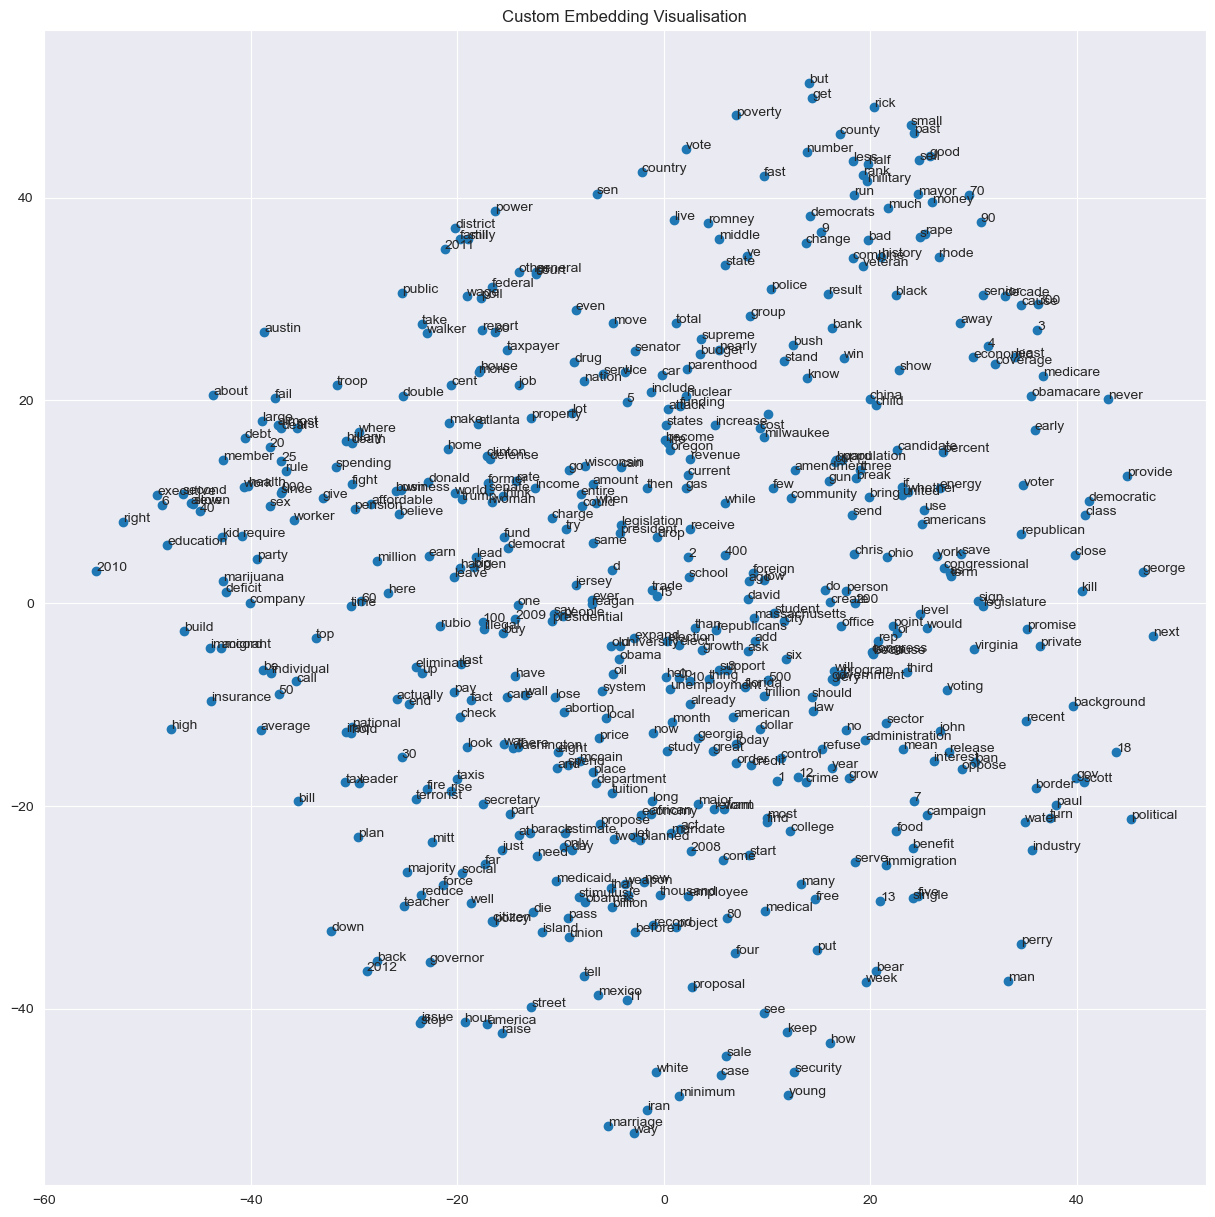

In [31]:
visualize_embeddings(embedding_matrix_custom,
                     vocabulary_dict_custom,
                     num_words=500,
                     plot_title='Custom Embedding Visualisation')


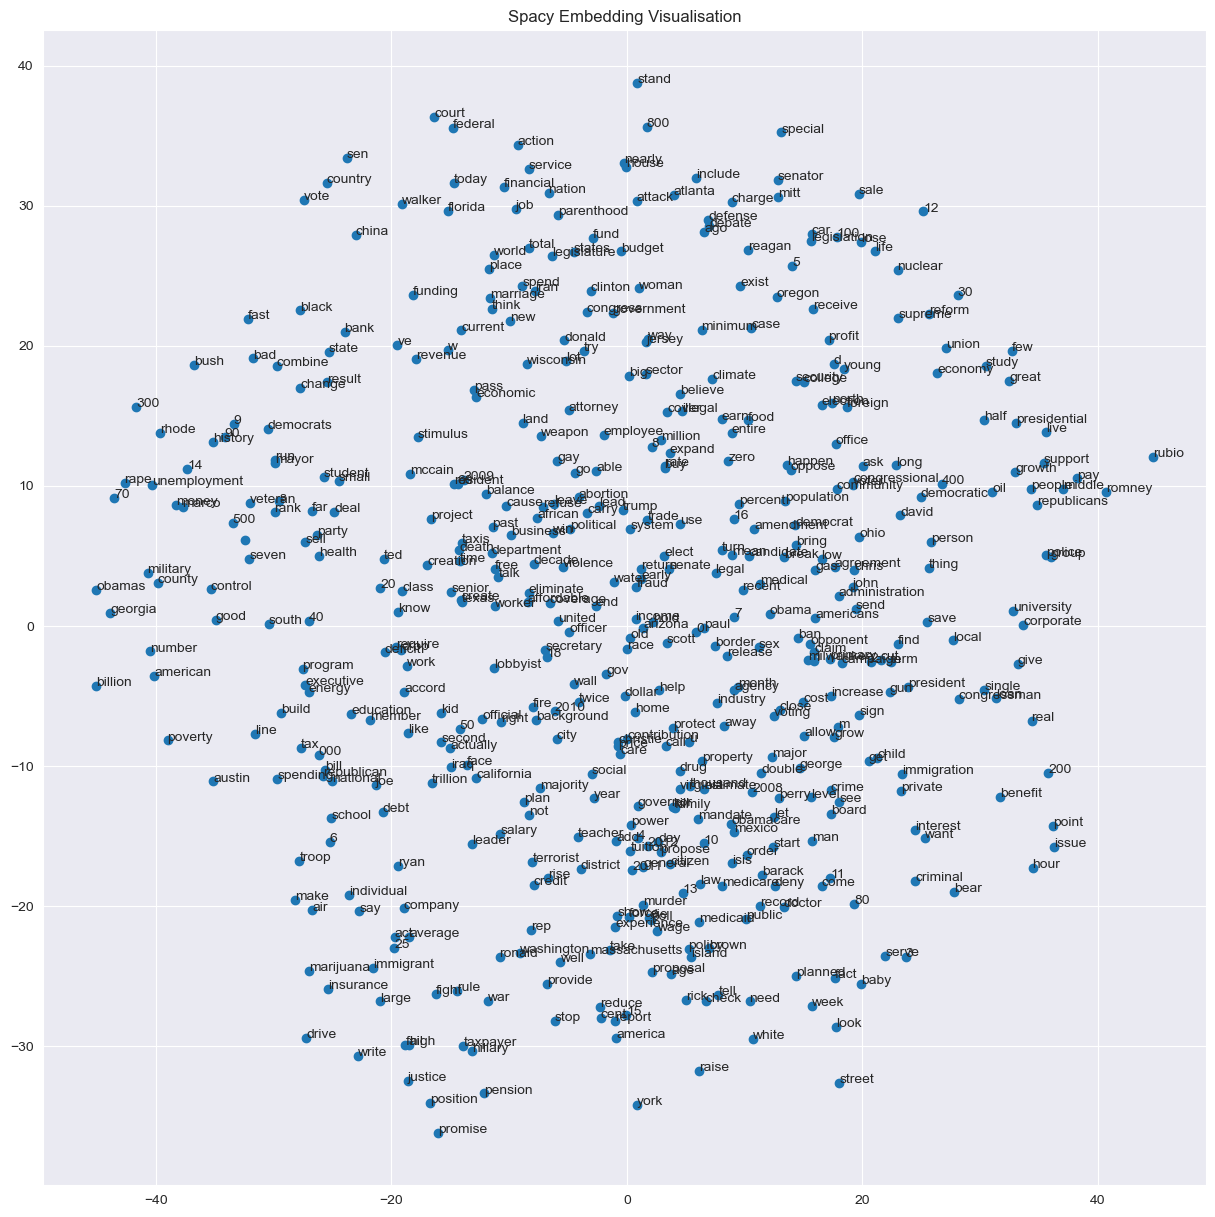

In [32]:
visualize_embeddings(embedding_matrix_spacy,
                     vocabulary_dict_spacy,
                     num_words=500,
                     plot_title='Spacy Embedding Visualisation')

In [33]:
from wordcloud import WordCloud

def plot_word_cloud(vocabulary):
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate_from_frequencies(vocabulary)

    # Display the generated image:
    plt.figure(figsize=(24,20))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

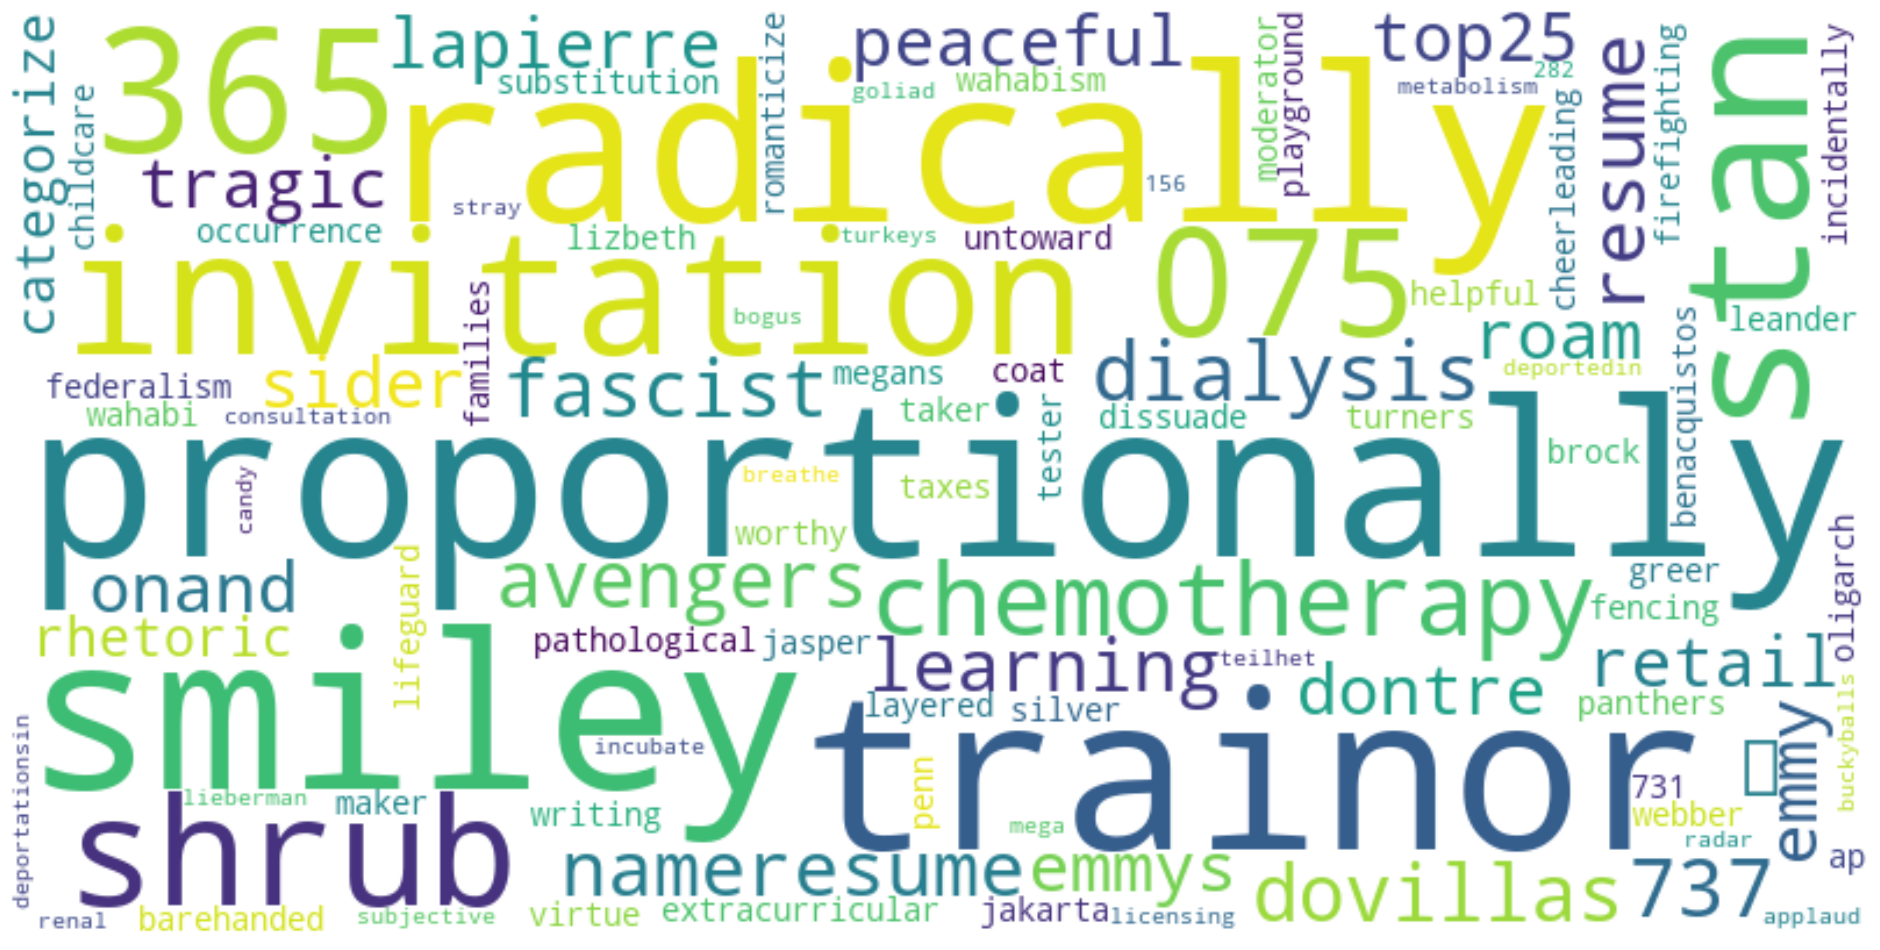

In [34]:
plot_word_cloud(vocabulary_dict_custom)

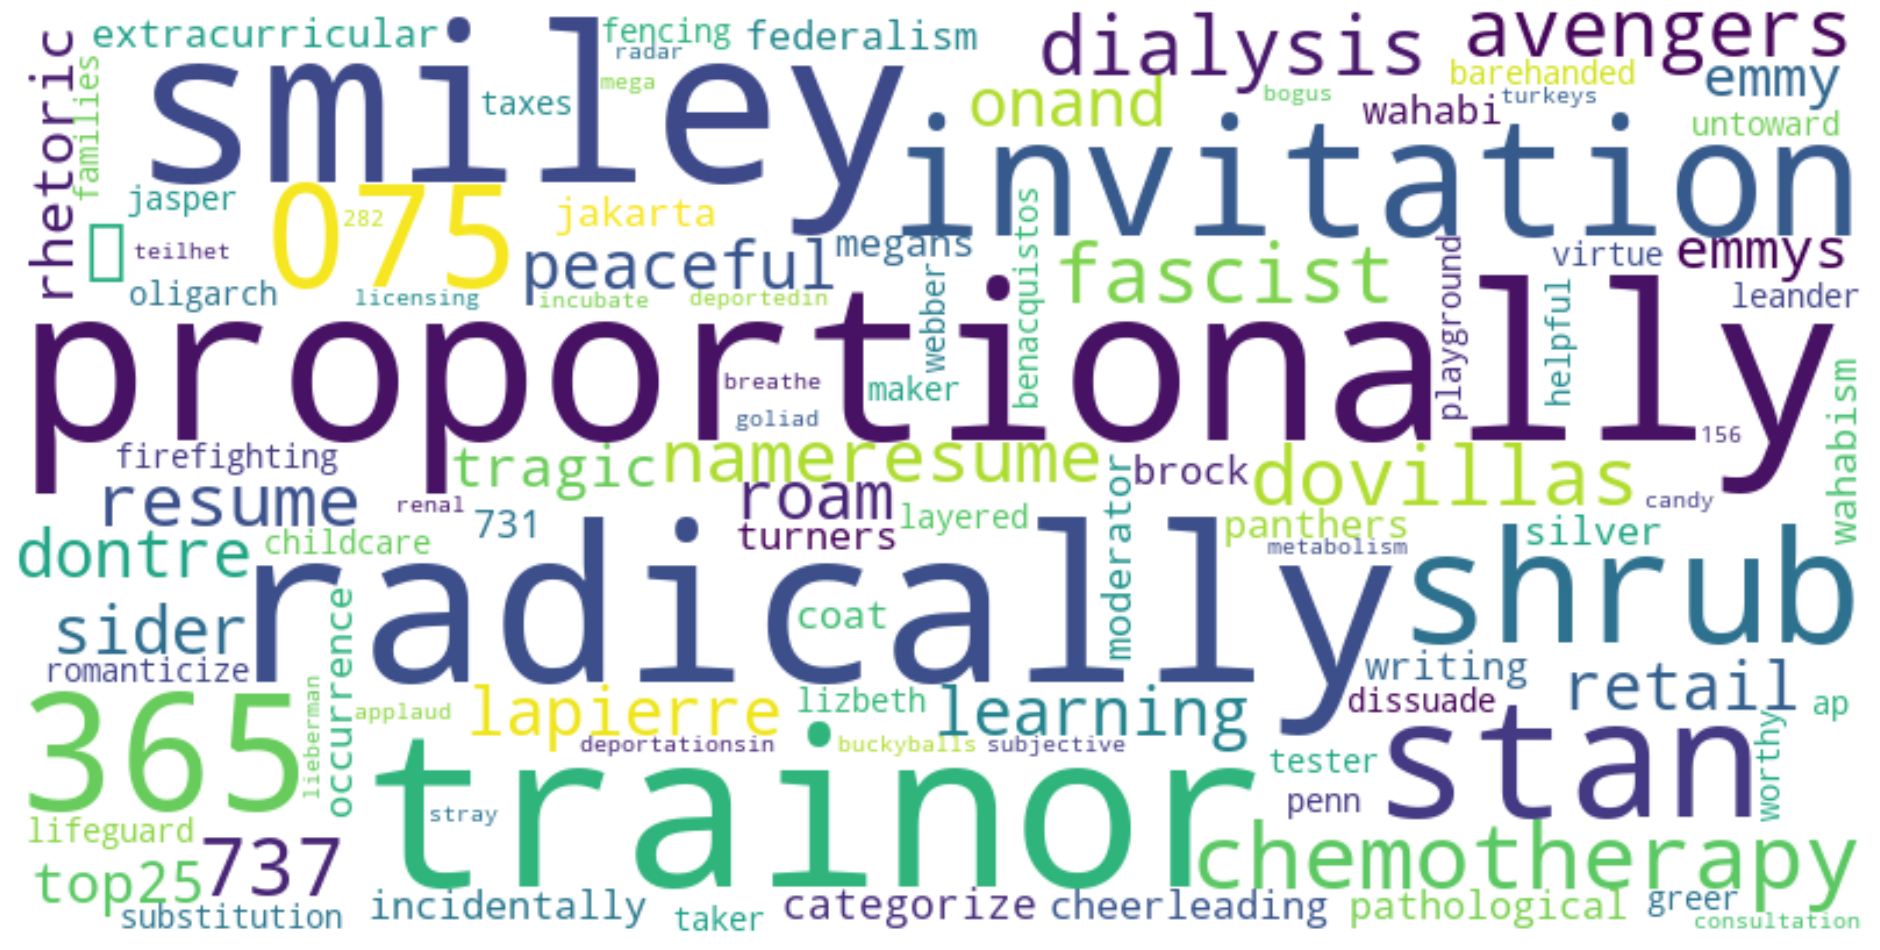

In [35]:
plot_word_cloud(vocabulary_dict_spacy)